# Circadian Detection Pipeline

In [80]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [81]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [82]:
%%capture

import circadian
reload(circadian)


first_day_with_data = '2024-07-14'
today = '2025-03-25'

all_days = [d.strftime('%Y-%m-%d') for d in pd.date_range(first_day_with_data, today)]

all_raw_data = circadian.fetch_raw_data(day_data, all_days)


In [83]:
import circadian
reload(circadian)

all_processed = circadian.process_raw_data(all_raw_data)


c:\dev\Brainwave-Processor\notebooks\CircadianDetection\circadian.py:99: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  local_valley_idx = window.idxmin()
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\pandas\core\generic.py:4106: RuntimeWarning: invalid value encountered in cast
  indices = np.asarray(indices, dtype=np.intp)


In [84]:
import sleep_events
reload(sleep_events)

import circadian
reload(circadian)

cr, cr_df = circadian.get_circadian_reviews()

Getting circadian rhythm reviews
Starting to process circadian rhythm reviews


In [85]:
[col for col in day_data.columns if 'night:aggregated:timeAwakeAfterSleepSecs' in col.lower()]







[]

In [86]:
day_data_insomniac_nights = day_data[day_data['night:aggregated:timeAwakeAfterSleepSecs'] > 60 * 60]
insomniac_nights = day_data_insomniac_nights['dayAndNightOf'].unique()


In [87]:
first_day_with_data = min(all_processed.keys())
today = pd.Timestamp.now().strftime('%Y-%m-%d')
all_days = [d.strftime('%Y-%m-%d') for d in pd.date_range(first_day_with_data, today)]
three_months_ago = (pd.Timestamp.now() - pd.Timedelta(days=90)).strftime('%Y-%m-%d')
last_3_months = [d.strftime('%Y-%m-%d') for d in pd.date_range(three_months_ago, today)]

all_processed_last_3_months = {
    day: data 
    for day, data in all_processed.items() 
    if day in last_3_months
}


In [88]:
all_processed_no_insomniac_nights = {
    day: data 
    for day, data in all_processed.items() 
    if day not in insomniac_nights
}
all_processed_insomniac_nights = {
    day: data 
    for day, data in all_processed.items() 
    if day in insomniac_nights
}

# Detecting LEP

In [89]:
import circadian
reload(circadian)

cr_known_lep = circadian.cr_known(cr_df, 'LEP')
cr_known_lep.head()

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence
1,2024-06-08,2024-06-08 22:36:00+01:00,37.23,0.680
2,2024-06-09,2024-06-09 22:28:00+01:00,37.18,0.290
3,2024-06-10,2024-06-10 22:28:00+01:00,37.16,0.300
5,2024-07-14,2024-07-14 22:48:00+01:00,37.02,0.405
8,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.140


# Detecting MP1

In [90]:
import circadian
reload(circadian)

# Merge MP1 and MP2, taking the latest, and calling that MP1.  It's unclear enough trying to pick them out without differentiating.

import circadian
reload(circadian)

cr, cr_df = circadian.get_circadian_reviews()

cr_known_mp1 = circadian.cr_known(cr_df, 'MP1')
cr_known_mp2 = circadian.cr_known(cr_df, 'MP2')

mp1_df = cr_known_mp1.rename(columns={
    'MP1_cr_datetime': 'MP_cr_datetime',
    'MP1_cr_temp': 'MP_cr_temp',
    'MP1_cr_prominence': 'MP_cr_prominence'
})
mp2_df = cr_known_mp2.rename(columns={
    'MP2_cr_datetime': 'MP_cr_datetime',
    'MP2_cr_temp': 'MP_cr_temp',
    'MP2_cr_prominence': 'MP_cr_prominence'
})

# Combine and sort by date and time
combined = pd.concat([mp1_df, mp2_df])
combined = combined.sort_values(['dayAndNightOf', 'MP_cr_datetime'])

# Keep the last entry for each day
merged = combined.groupby('dayAndNightOf').last().reset_index()

cr_known_mp1 = merged[['dayAndNightOf', 'MP_cr_datetime', 'MP_cr_temp', 'MP_cr_prominence']]
cr_known_mp1.head()

Getting circadian rhythm reviews
Starting to process circadian rhythm reviews


,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence
0,2024-06-10,2024-06-10 09:54:00+01:00,36.84,0.24
1,2024-07-15,2024-07-15 10:50:00+01:00,36.73,0.08
2,2024-07-16,2024-07-16 10:28:00+01:00,36.93,0.15
3,2024-07-22,2024-07-22 10:04:00+01:00,36.84,0.22
4,2024-07-23,2024-07-23 10:26:00+01:00,37.10,0.48


# Extracting & drawing features

In [91]:
cr_known_mp1

,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence
0,2024-06-10,2024-06-10 09:54:00+01:00,36.84,0.24
1,2024-07-15,2024-07-15 10:50:00+01:00,36.73,0.08
2,2024-07-16,2024-07-16 10:28:00+01:00,36.93,0.15
3,2024-07-22,2024-07-22 10:04:00+01:00,36.84,0.22
4,2024-07-23,2024-07-23 10:26:00+01:00,37.10,0.48
...,...,...,...,...
159,2025-05-04,2025-05-04 09:00:00+01:00,37.50,1.07
160,2025-05-06,2025-05-06 08:26:00+01:00,37.09,0.25
161,2025-05-07,2025-05-07 07:46:00+01:00,37.10,0.69
162,2025-05-08,2025-05-08 07:14:00+01:00,36.92,0.17


In [104]:
joined_lep_df = cr_known_lep
joined_mp1_df = cr_known_mp1

def merge_all_types(exclude_insomniac_nights=True, verbose=False):
    out = []
    if joined_lep_df is not None:
        out.append(joined_lep_df)
    if joined_mp1_df is not None:
        out.append(joined_mp1_df)
                
    if len(out) == 0:
        if verbose:
            print("No data to merge")
        return None
    if len(out) == 1:
        if verbose:
            print("Only one type of data to merge")
        return out[0]
    
    # Merge all DataFrames in the list
    result = out[0]
    for df in out[1:]:
        result = pd.merge(result, df, on='dayAndNightOf', how='outer')

    # Detect types and create merged columns
    types = set()
    for col in result.columns:
        if col.endswith('_cr_datetime'):
            type_name = col.split('_cr_')[0]
            types.add(type_name)
    
    # Create merged columns for each type
    for type_name in types:
        # Datetime
        cr_datetime = f'{type_name}_cr_datetime'
        result[f'{type_name}_merge_datetime'] = result[cr_datetime]
        
        # Temperature
        cr_temp = f'{type_name}_cr_temp'
        result[f'{type_name}_merge_temp'] = result[cr_temp]
        
        # Prominence (only exists in cr data)
        if f'{type_name}_cr_prominence' in result.columns:
            result[f'{type_name}_merge_prominence'] = result[f'{type_name}_cr_prominence']
    
    result['MP_To_LEP'] = result['LEP_cr_datetime'] - result['MP_cr_datetime']

    if exclude_insomniac_nights:
        result = result[~result['dayAndNightOf'].isin(insomniac_nights)]

    return result

merged = merge_all_types()
if merged is not None:
    merged.head()
else:
    print("No merged data") 

merged

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence,MP_cr_datetime,MP_cr_temp,MP_cr_prominence,LEP_merge_datetime,LEP_merge_temp,LEP_merge_prominence,MP_merge_datetime,MP_merge_temp,MP_merge_prominence,MP_To_LEP
0,2024-06-08,2024-06-08 22:36:00+01:00,37.23,0.680,NaT,NaN,NaN,2024-06-08 22:36:00+01:00,37.23,0.680,NaT,NaN,NaN,NaT
1,2024-06-09,2024-06-09 22:28:00+01:00,37.18,0.290,NaT,NaN,NaN,2024-06-09 22:28:00+01:00,37.18,0.290,NaT,NaN,NaN,NaT
2,2024-06-10,2024-06-10 22:28:00+01:00,37.16,0.300,2024-06-10 09:54:00+01:00,36.84,0.24,2024-06-10 22:28:00+01:00,37.16,0.300,2024-06-10 09:54:00+01:00,36.84,0.24,0 days 12:34:00
3,2024-07-14,2024-07-14 22:48:00+01:00,37.02,0.405,NaT,NaN,NaN,2024-07-14 22:48:00+01:00,37.02,0.405,NaT,NaN,NaN,NaT
4,2024-07-15,NaT,NaN,NaN,2024-07-15 10:50:00+01:00,36.73,0.08,NaT,NaN,NaN,2024-07-15 10:50:00+01:00,36.73,0.08,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,2025-05-05,2025-05-05 21:26:00+01:00,37.23,0.840,NaT,NaN,NaN,2025-05-05 21:26:00+01:00,37.23,0.840,NaT,NaN,NaN,NaT
234,2025-05-06,NaT,NaN,NaN,2025-05-06 08:26:00+01:00,37.09,0.25,NaT,NaN,NaN,2025-05-06 08:26:00+01:00,37.09,0.25,NaT
235,2025-05-07,NaT,NaN,NaN,2025-05-07 07:46:00+01:00,37.10,0.69,NaT,NaN,NaN,2025-05-07 07:46:00+01:00,37.10,0.69,NaT
236,2025-05-08,NaT,NaN,NaN,2025-05-08 07:14:00+01:00,36.92,0.17,NaT,NaN,NaN,2025-05-08 07:14:00+01:00,36.92,0.17,NaT


In [93]:
import circadian
reload(circadian)

post_lep_stats = circadian.calc_avg_mins_after_lep(all_processed, merge_all_types(), 2.5 * 60)
if post_lep_stats is not None:
    display(post_lep_stats.describe())
else:
    print("No post LEP stats")


,minute,mean,std1_lower,std1_upper,std2_lower,std2_upper
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,75.000000,36.704915,36.544471,36.865358,36.384027,37.025802
std,43.734045,0.215885,0.218619,0.213755,0.221937,0.212249
min,0.000000,36.452487,36.310131,36.589138,36.157561,36.725788
25%,37.500000,36.493715,36.330739,36.656692,36.175586,36.819668
50%,75.000000,36.670080,36.497345,36.842815,36.324610,37.017528
75%,112.500000,36.882403,36.721685,37.043121,36.560966,37.203915
max,150.000000,37.111482,36.961243,37.261762,36.811003,37.412149


In [94]:
import circadian
reload(circadian)


def do_it_all(day: str, start_time: str = '06:00:00Z', end_time: str = '12:00:00Z'):
    merged = merge_all_types()
    chart = circadian.do_it_all(day_data, day, start_time, end_time, merged, all_processed, post_lep_stats)
    display(chart)
    if merged is not None:
        vs_lep_avg = circadian.compare_night_to_average(all_processed, merged, post_lep_stats, day)
        display("Comparing to average period after LEP", vs_lep_avg)

do_it_all('2024-08-06', '19:00:00Z', '08:00:00Z') 

C:\Users\graha\AppData\Roaming\Python\Python313\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'examined-life.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


alt.VConcatChart(...)

'Comparing to average period after LEP'

{'minutes_above_mean': 120, 'minutes_below_mean': 0}

In [95]:
def debug_day(day):
    if day in insomniac_nights:
        print(f"Day {day} is an insomniac night")

    if all_processed.get(day) is None:
        print(f"No all_processed data for day {day}")
        return

    if 'df' in all_processed[day]:
        df = all_processed[day]['df']
        print(f"df has {len(df)} rows of temp data")
        print(df.describe())
    else:
        print(f"No df for day {day}")

    if 'dd' in all_processed[day]:
        dd = all_processed[day]['dd']
        if 'wakeTime' in dd.columns:
            wake_time = dd['wakeTime'].iloc[0]
            if pd.notna(wake_time):
                print(f"Wake time found for day {day}: {wake_time}")
            else:
                print(f"No wake time found for day {day}")
        else:
            print(f"No wake time found for day {day}")

        if 'asleepTime' in dd.columns:
            sleep_time = dd['asleepTime'].iloc[0]
            if pd.notna(sleep_time):
                print(f"Sleep time found for day {day}: {sleep_time}")
            else:
                print(f"No sleep time found for day {day}")
        else:
            print(f"No sleep time found for day {day}")
    else:
        print(f"No dd data for day {day} (probably need to do morning review)")  

    cr_df_day = cr_df[cr_df['dayAndNightOf'] == day]
    if cr_df_day.empty:
        print(f"No cr data for day {day} (probably need to do circadian review)")
    else:
        print(f"CR data for day {day}:")
        cols = [c for c in cr_df_day.columns if 'LEP_' in c or 'MP_' in c]
        display(cr_df_day[cols])


    joined_lep_df_day = joined_lep_df[joined_lep_df['dayAndNightOf'] == day]    
    if joined_lep_df_day is not None:
        print(f"LEP data in joined_lep_df_day:")  
        display(joined_lep_df_day)
    else:
        print(f"No LEP data in joined_lep_df_day")

    # joined_lt1_df_day = joined_lt1_df[joined_lt1_df['dayAndNightOf'] == day]
    # if joined_lt1_df_day is not None:
    #     print(f"LT1 data for day {day}:")
    #     display(joined_lt1_df_day)
    # else:
    #     print(f"No LT1 data in joined_lt1_df_day")

    joined_mp1_df_day = joined_mp1_df[joined_mp1_df['dayAndNightOf'] == day]
    if joined_mp1_df_day is not None:
        print(f"MP1 data for day {day}:")
        display(joined_mp1_df_day)
    else:
        print(f"No MP1 data in joined_mp1_df_day")

    merged_df = merge_all_types(verbose=True)
    if merged_df is None:
        print(f"No merged data at all yet")
        return
    else:
        merged_df_day = merged_df[merged_df['dayAndNightOf'] == day]
        if merged_df_day.empty:
            print(f"No merged data for day {day}")
            return
        else:
            lep_time = merged_df_day['LEP_cr_datetime'].iloc[0]
            if pd.isna(lep_time):
                print(f"No LEP time found for day {day}")
            else:
                print(f"LEP time found for day {day}: {lep_time}")

debug_day('2024-09-09')


df has 2161 rows of temp data
              Temp  Temp_Interpolated  Temp_Smoothed_Savgol
count  1418.000000        1490.000000           1461.000000
mean     36.745759          36.744372             36.747560
std       0.209162           0.207979              0.208370
min      36.230000          36.230000             36.230452
25%      36.597927          36.590000             36.597626
50%      36.830000          36.820000             36.832085
75%      36.891315          36.890000             36.894348
max      37.140000          37.140000             37.141746
No wake time found for day 2024-09-09
No sleep time found for day 2024-09-09
CR data for day 2024-09-09:


,LEP_status,LEP_datetime,LEP_prominence,LEP_temp
62,Selected,2024-09-09 20:20:00+00:00,0.33,37.02


LEP data in joined_lep_df_day:


,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence
62,2024-09-09,2024-09-09 21:20:00+01:00,37.02,0.33


MP1 data for day 2024-09-09:


,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence
31,2024-09-09,2024-09-09 08:54:00+01:00,37.14,0.74


LEP time found for day 2024-09-09: 2024-09-09 21:20:00+01:00


# Exploring initial drop after LEP

Identifying LT1 is proving tricky.  It doesn't always plummet in a nice clean way to a nice clean bottom.

Might be easier to identify features like amount of drop in first 2 hours after LEP.

Or % of total night's low covered in first 2 hours.

May be interesting to see all charts on one, for the first 2 hours after LEP, that sort of thing.

Sleep mean as mins past LEP: 77.8 minutes +/- 32.8 minutes (= 68% of values are between 45.0 and 110.6 minutes after LEP)


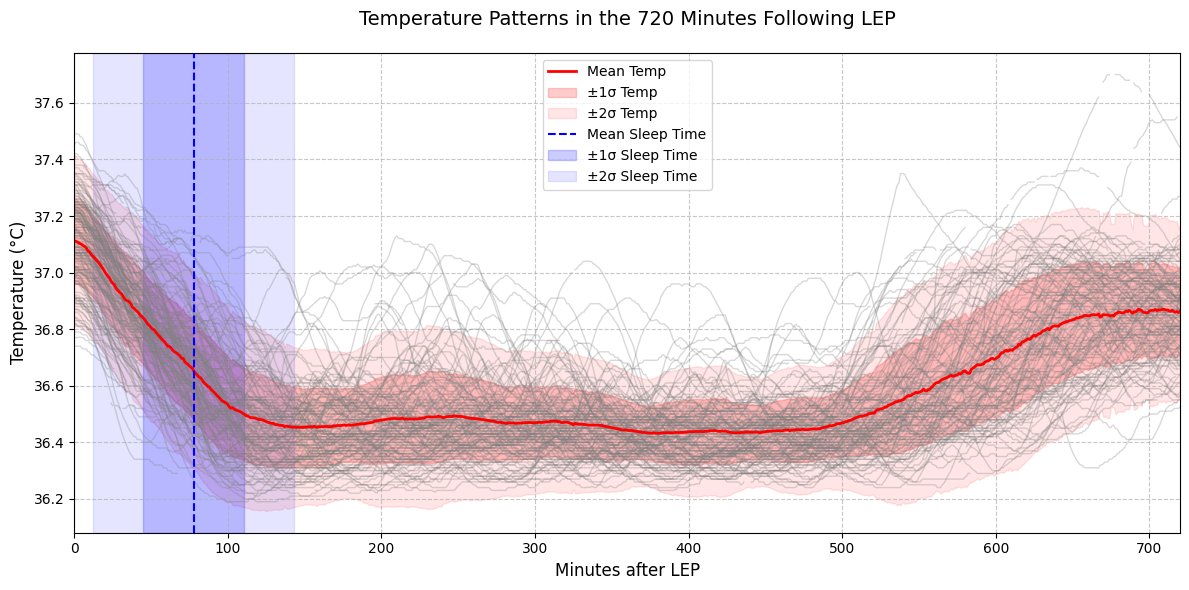

In [96]:

import matplotlib as plt
import circadian
reload(circadian)


first_day = all_processed.keys  
all_days = [d.strftime('%Y-%m-%d') for d in pd.date_range(first_day_with_data, today)]
last_3_months = [   ]


fig = circadian.plot_post_lep_periods_matplotlib(all_processed, merge_all_types(), 12 * 60)

In [140]:
import circadian
reload(circadian)

post_lep_stats = circadian.calc_post_lep_stats(all_processed, merge_all_types(), 12 * 60)
post_lep_stats.to_csv("C:\\dev\\play\\brainwave-data\\post_lep_stats.csv")

Sleep mean as mins past LEP: 78.2 minutes +/- 33.1 minutes (= 68% of values are between 45.1 and 111.3 minutes after LEP)


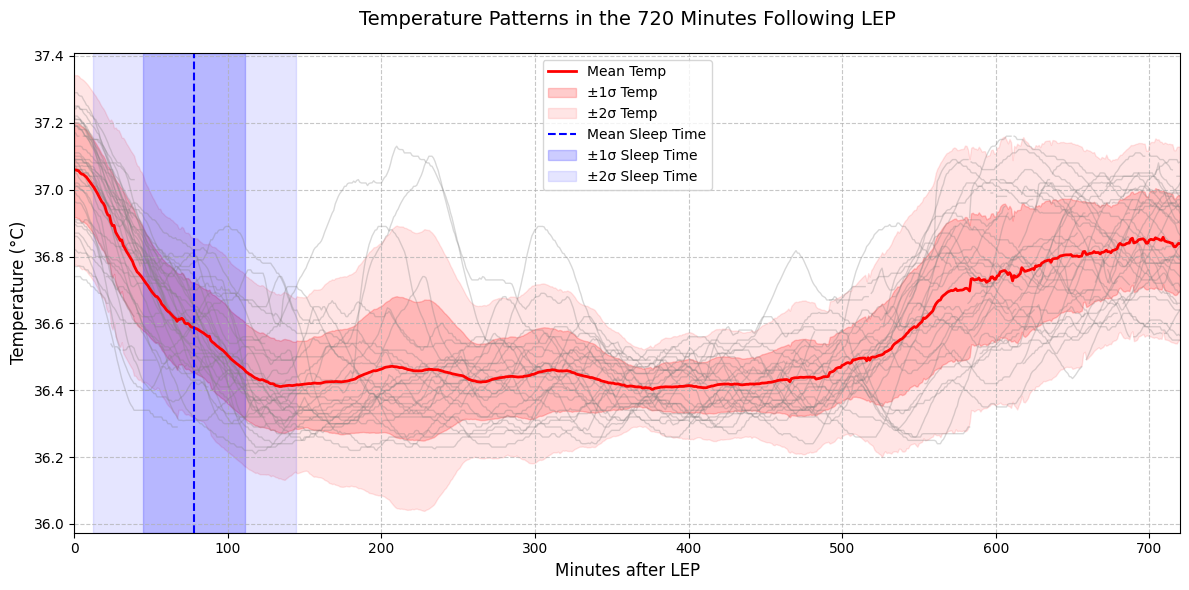

In [97]:
fig = circadian.plot_post_lep_periods_matplotlib(all_processed_last_3_months, merge_all_types(), 12 * 60)

Next

* Detect amount of time above and below mean, and how much.
* Look at steep and slow descenders.
* Look at those that don't descend cleanly.
* Do any of these correlate to e.g. more or stronger deep sleep? 

In [98]:
# import circadian
# reload(circadian)

# # Create list to store results
# all_nights_analysis = []

# m = merge_all_types()
# # Analyze each night
# for day in all_processed.keys():
#     metrics = circadian.compare_night_to_average(all_processed, m, post_lep_stats, day)
#     if metrics is not None:
#         metrics['dayAndNightOf'] = day
#         all_nights_analysis.append(metrics)

# # Convert to DataFrame
# nights_df = pd.DataFrame(all_nights_analysis)

# # Reorder columns to put dayAndNightOf first
# cols = ['dayAndNightOf'] + [col for col in nights_df.columns if col != 'dayAndNightOf']
# nights_df = nights_df[cols]

# # Sort by date
# nights_df = nights_df.sort_values('dayAndNightOf')
# nights_df.head()

In [130]:
import circadian
reload(circadian)

# Create list to store results
all_nights_analysis = []

m = merge_all_types()
# Analyze each night
for day in all_processed.keys():
    metrics = circadian.compare_night_to_average(all_processed, m, post_lep_stats, day)
    if metrics is not None:
        metrics['dayAndNightOf'] = day
        all_nights_analysis.append(metrics)

# Convert to DataFrame
nights_df = pd.DataFrame(all_nights_analysis)

# Reorder columns to put dayAndNightOf first
cols = ['dayAndNightOf'] + [col for col in nights_df.columns if col != 'dayAndNightOf']
nights_df = nights_df[cols]

# Sort by date
nights_df = nights_df.sort_values('dayAndNightOf')
# nights_df.index = nights_df['dayAndNightOf']
# nights_df.drop(columns=['dayAndNightOf'], inplace=True)
nights_df.head()

,dayAndNightOf,minutes_above_mean,minutes_below_mean
0,2024-07-14,0,30
1,2024-07-17,0,34
2,2024-07-21,0,103
3,2024-07-22,0,120
4,2024-07-23,26,95


In [ ]:
# Convert dayAndNightOf to string in both dataframes
day_data_copy = day_data.copy()
day_data_copy = day_data_copy.reset_index(drop=True)
nights_df = nights_df.sort_values('dayAndNightOf')
# day_data_copy.drop(columns=['dayAndNightOf'], inplace=True)

nights_df['dayAndNightOf'] = nights_df['dayAndNightOf'].astype(str)
day_data_copy['dayAndNightOf'] = day_data_copy['dayAndNightOf'].astype(str)

# Merge the dataframes
merged_for_corr = pd.merge(nights_df, day_data_copy, on='dayAndNightOf', how='inner')

# Get numeric columns from day_data
numeric_cols = day_data.select_dtypes(include=['int64', 'float64']).columns

timedelta_cols = merged_for_corr.select_dtypes(include=['timedelta64[ns]']).columns
for col in timedelta_cols:
    merged_for_corr[col] = merged_for_corr[col].dt.total_seconds() / 60  # Convert to minutes

# Calculate correlations with valid counts
correlations_below_mean = []
correlations_above_mean = []
for col in numeric_cols:
    # Count valid pairs (where both columns have non-null values)
    valid_count = merged_for_corr[['minutes_below_mean', col]].dropna().shape[0]
    
    if valid_count >= 10:  # Only calculate correlation if we have enough data
        correlation = merged_for_corr['minutes_below_mean'].corr(merged_for_corr[col])
        correlations_below_mean.append({
            'column': col,
            'correlation': correlation,
            'valid_count': valid_count
        })

    valid_count = merged_for_corr[['minutes_above_mean', col]].dropna().shape[0]
    
    if valid_count >= 10:  # Only calculate correlation if we have enough data
        correlation = merged_for_corr['minutes_above_mean'].corr(merged_for_corr[col])
        correlations_above_mean.append({
            'column': col,
            'correlation': correlation,
            'valid_count': valid_count
        })

# Convert to DataFrame and sort by absolute correlation
corr_below_mean_df = pd.DataFrame(correlations_below_mean)
corr_below_mean_df['abs_correlation'] = corr_below_mean_df['correlation'].abs()
corr_below_mean_df = corr_below_mean_df.sort_values('abs_correlation', ascending=False)
corr_below_mean_df = corr_below_mean_df.drop('abs_correlation', axis=1)


corr_above_mean_df = pd.DataFrame(correlations_above_mean)
corr_above_mean_df['abs_correlation'] = corr_above_mean_df['correlation'].abs()
corr_above_mean_df = corr_above_mean_df.sort_values('abs_correlation', ascending=False)
corr_above_mean_df = corr_above_mean_df.drop('abs_correlation', axis=1)


# Display top correlations
print("Top correlations with minutes_below_mean (minimum 10 valid pairs):")
display(corr_below_mean_df)
print("Top correlations with minutes_above_mean (minimum 10 valid pairs):")
display(corr_above_mean_df)

,dayAndNightOf,date:daysSince,date:dayOfWeek,date:dayOfMonth,date:month,date:year,date:asStr,weather:cloudCoverAfternoon,weather:humidityAfternoon,weather:precipitationTotal,...,exercise:byExercise:Bike:totalDurationSecs,exercise:byExercise:Bike:totalCalories,exercise:byExercise:Bike:totalSteps,exercise:byExercise:Bike:averageHeartRate,asleepTime,wakeTime,gotIntoBedTime,readyToSleepTime,LEPTime,timeAwakeAfterSleep
0,2025-02-03,0,1,3,2,2025,2025-02-03,20,77,0.00,...,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,2025-02-03 21:20:00+00:00,NaT
1,2024-04-21,0,7,21,4,2024,2024-04-21,40,56,2.37,...,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT
2,2024-04-22,0,1,22,4,2024,2024-04-22,75,95,4.06,...,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT
3,2024-04-23,0,2,23,4,2024,2024-04-23,40,69,0.00,...,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT
4,2024-04-24,0,3,24,4,2024,2024-04-24,40,61,0.00,...,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT


c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\py3.13\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\U

Top correlations with minutes_below_mean (minimum 10 valid pairs):


,column,correlation,valid_count
1545,circadian:basic:entries:LT1:temp:onDayMinus1,-0.800315,12
1794,coreBodyTemp:GotIntoBedToMiddleOfSleep:mean,-0.723394,60
1797,coreBodyTemp:GotIntoBedToMiddleOfSleep:percentile90,-0.704513,60
376,circadian:basic:entries:LEP:temp,-0.671005,165
1406,circadian:combined:entries:LEP:temp,-0.649175,83
...,...,...,...
1870,events:startingPaidWork:count,NaN,15
1883,night:morningQuestionnaire:duvets:duvet1:code,NaN,19
1903,events:sexWithClimax:count,NaN,31
1904,events:sexWithoutClimax:count,NaN,31


Top correlations with minutes_above_mean (minimum 10 valid pairs):


,column,correlation,valid_count
1545,circadian:basic:entries:LT1:temp:onDayMinus1,0.824630,12
376,circadian:basic:entries:LEP:temp,0.706456,165
1406,circadian:combined:entries:LEP:temp,0.660068,83
1797,coreBodyTemp:GotIntoBedToMiddleOfSleep:percentile90,0.650808,60
1794,coreBodyTemp:GotIntoBedToMiddleOfSleep:mean,0.624426,60
...,...,...,...
1870,events:startingPaidWork:count,NaN,15
1883,night:morningQuestionnaire:duvets:duvet1:code,NaN,19
1903,events:sexWithClimax:count,NaN,31
1904,events:sexWithoutClimax:count,NaN,31


In [136]:
from notebooks.Util.MlKeys import sleep_factors, potential_sleep_affectors

#cols_to_include = [c for c in corr_df['column'] if not (c.startswith('circadian') or c.startswith('coreBodyTemp'))]

#use = corr_below_mean_df[corr_below_mean_df['column'].isin(potential_sleep_affectors)]

use = corr_above_mean_df[corr_above_mean_df['column'].isin(sleep_factors)]
df = use[use['correlation'].abs() > 0.1]
df

,column,correlation,valid_count
1891,movement:AsleepToAwake:mean,0.402158,19
1576,o2:AsleepToAwake:percentile90,0.345974,36
1543,coreBodyTemp:AsleepToAwake:percentile90,0.323107,67
1540,coreBodyTemp:AsleepToAwake:mean,0.321197,67
1542,coreBodyTemp:AsleepToAwake:percentile10,0.282624,67
1107,night:yasaExtended:Sleep:alphaabs:mean,-0.225904,81
498,night:aggregated:totalSleepTimeSecs,0.220385,83
1399,night:aggregated:microwakingsWithinRemPerHour,0.208608,83
581,night:yasa:adjusted:remSleepSecs,0.205546,83
723,night:yasaExtended:N2:alphaabs:mean,-0.204196,81


In [137]:
import altair as alt


col = "night:yasaExtended:N3:alphaabs:mean"
against = "minutes_above_mean"



plot_df = pd.DataFrame({
    'dayAndNightOf': merged_for_corr['dayAndNightOf'],
    'x': merged_for_corr[col],
    'y': merged_for_corr[against]
}).dropna()  # Remove any rows with missing values

# Calculate correlation
correlation = plot_df['x'].corr(plot_df['y'])

# Create scatter plot with trend line
scatter = alt.Chart(plot_df).mark_circle().encode(
    x=alt.X('x:Q', 
            title=col,
            scale=alt.Scale(zero=False)),
    y=alt.Y('y:Q', 
            title=against,
            scale=alt.Scale(zero=False)),
    tooltip=['dayAndNightOf', 
            alt.Tooltip('x:Q', format='.2f'),
            alt.Tooltip('y:Q', format='.2f')]
)

# Add trend line
trend_line = scatter.transform_regression('x', 'y').mark_line(
    color='red',
    strokeDash=[8, 4]
)

# Combine scatter and trend line
chart = (scatter + trend_line).properties(
    width=600,
    height=400,
    title=f'{against} vs {col} (r={correlation:.3f})'
)

# Display correlation and the chart
print(f"Correlation: {correlation:.3f}")
display(plot_df.head())
chart

Correlation: -0.185


,dayAndNightOf,x,y
0,2024-07-14,0.010920,0
1,2024-07-17,0.009807,0
2,2024-07-21,0.010989,0
3,2024-07-22,0.009214,0
19,2024-08-18,0.014054,30


alt.LayerChart(...)

# Look for patterns between MP and LEP

In [102]:
import circadian
reload(circadian)

circadian.draw_mp_to_lep_2(merge_all_types())

Average Morning Peak: 8:39 ± 0.90h
Average Late Evening Peak: 21:47 ± 0.53h
Average time difference: 13.12 hours


alt.LayerChart(...)

In [105]:
import circadian
reload(circadian)

circadian.draw_mp_to_lep(merge_all_types())

Mean time from MP to LEP: 13.14 hours
Standard deviation: 0.88 hours


alt.LayerChart(...)

Need to handle missing data days (2025-03-15)
And not present (2025-03-13)

# Looking at N hours before MP 

Wake mean as mins before MP: 88.4 minutes +/- 15.9 minutes (= 68% of values are between 72.5 and 104.4 minutes before MP)


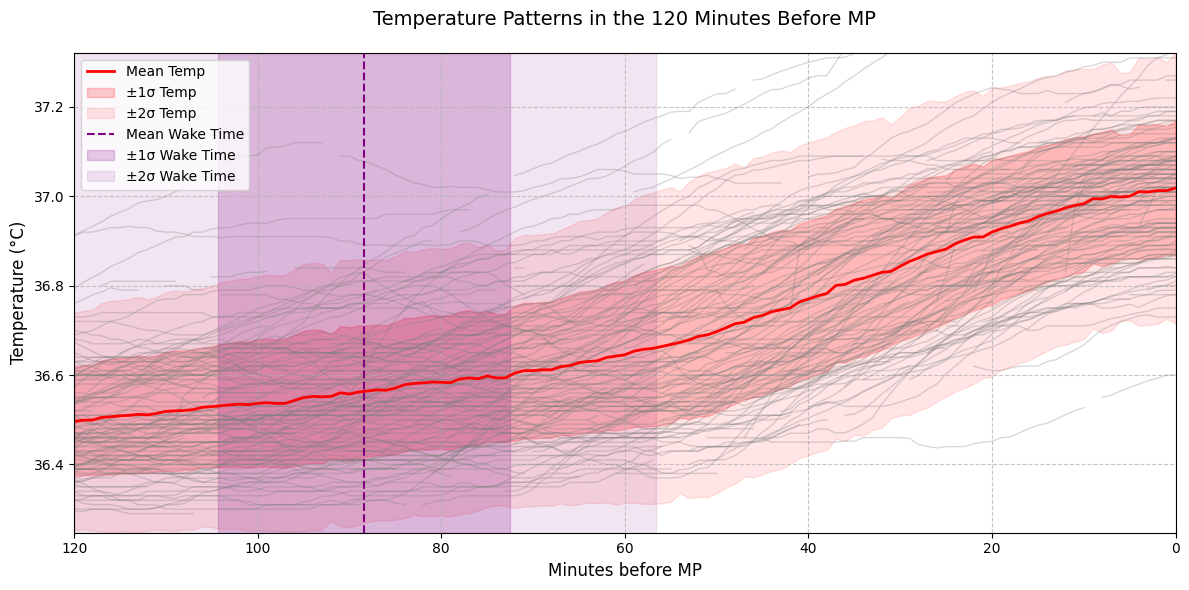

In [107]:

import circadian
reload(circadian)

fig = circadian.plot_pre_mp_periods_matplotlib(all_processed_no_insomniac_nights, merge_all_types(), 2 * 60)

# Looking at N hours after MP

In [ ]:

import circadian
reload(circadian)

fig = circadian.plot_pre_mp_periods_matplotlib(all_processed_no_insomniac_nights, merge_all_types(), 2 * 60)

In [142]:
import circadian
reload(circadian)

circadian.calc_pre_mp_stats(all_processed, merge_all_types(), 2 * 60)

,minute,mean,std1_lower,std1_upper,std2_lower,std2_upper
0,0.0,37.013187,36.866886,37.159488,36.720586,37.305789
1,5.0,36.997622,36.854906,37.140338,36.712189,37.283054
2,10.0,36.973223,36.823205,37.123242,36.673186,37.273260
3,15.0,36.940067,36.785957,37.094178,36.631847,37.248288
4,20.0,36.906310,36.746436,37.066185,36.586561,37.226060
5,25.0,36.868076,36.701792,37.034359,36.535509,37.200642
6,30.0,36.826711,36.658634,36.994787,36.490558,37.162864
7,35.0,36.792906,36.621370,36.964442,36.449834,37.135978
8,40.0,36.752561,36.579130,36.925991,36.405699,37.099422
9,45.0,36.718541,36.544197,36.892886,36.369853,37.067230


# Looking at LEP through to MP and highlighting some days

In [108]:
import circadian
reload(circadian)

#test
day = '2024-09-09'
circadian.prepare_pre_mp_data(all_processed, merge_all_types(), all_processed[day], day, True)

No MP time found for day 2024-09-10


(             day  minutes_after_lep       Temp
 1220  2024-09-09                0.0  37.020000
 1221  2024-09-09                1.0  37.020000
 1222  2024-09-09                2.0  37.018444
 1223  2024-09-09                3.0  37.010000
 1224  2024-09-09                4.0  37.010000
 ...          ...                ...        ...
 1336  2024-09-09              116.0  36.499038
 1337  2024-09-09              117.0  36.486667
 1338  2024-09-09              118.0  36.475000
 1339  2024-09-09              119.0  36.470000
 1340  2024-09-09              120.0  36.466400
 
 [121 rows x 3 columns],
 None,
 None)

In [109]:
debug_day('2024-11-05')

df has 2161 rows of temp data
              Temp  Temp_Interpolated  Temp_Smoothed_Savgol
count  1017.000000        1066.000000           1009.000000
mean     36.657309          36.663424             36.654514
std       0.269836           0.267095              0.268965
min      36.270000          36.270000             36.272796
25%      36.350000          36.359413             36.351886
50%      36.700000          36.700000             36.693912
75%      36.890000          36.890000             36.889791
max      37.150000          37.150000             37.151500
Wake time found for day 2024-11-05: 2024-11-06 02:37:00+00:00
Sleep time found for day 2024-11-05: 2024-11-05 23:11:30+00:00
CR data for day 2024-11-05:


,LEP_status,LEP_datetime,LEP_prominence,LEP_temp
119,Selected,2024-11-05 21:42:00+00:00,0.51,37.15


LEP data in joined_lep_df_day:


,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence
119,2024-11-05,2024-11-05 21:42:00+00:00,37.15,0.51


MP1 data for day 2024-11-05:


,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence
61,2024-11-05,2024-11-05 08:52:00+00:00,37.09,0.27


LEP time found for day 2024-11-05: 2024-11-05 21:42:00+00:00


Sleep mean as mins past LEP: 76.8 minutes +/- 33.7 minutes (= 68% of values are between 43.1 and 110.5 minutes after LEP)
Wake mean as mins past LEP: 535.8 minutes +/- 65.4 minutes (= 68% of values are between 470.4 and 601.3 minutes after LEP)


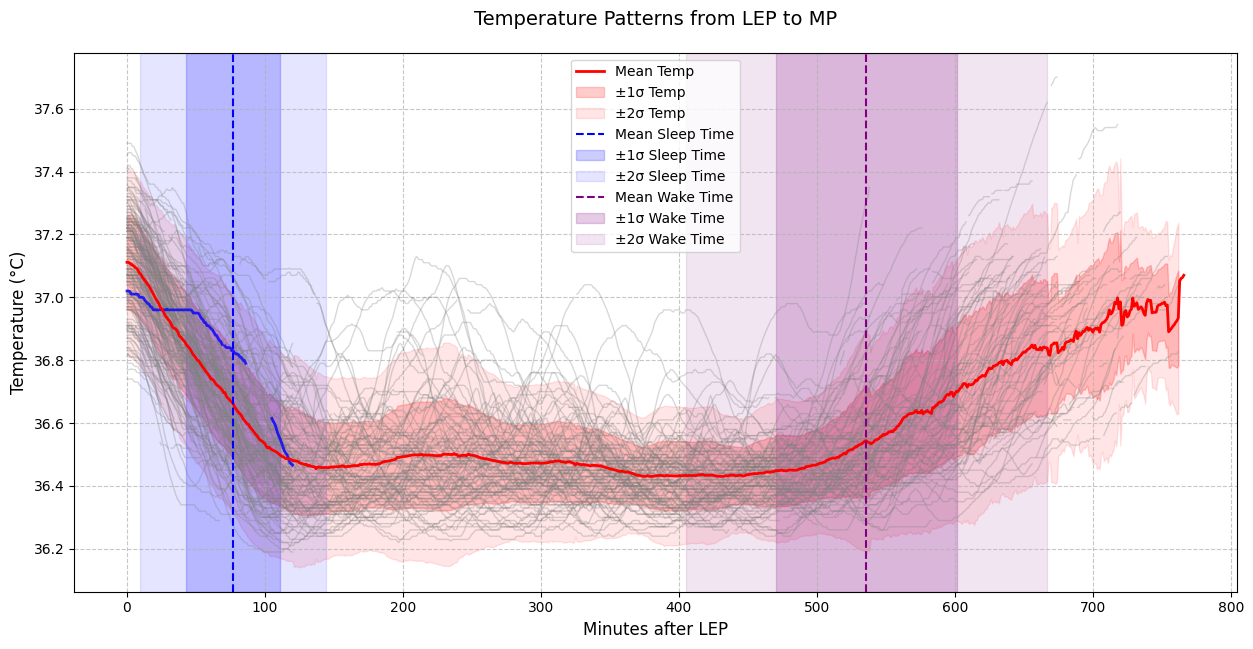

In [110]:
import circadian
reload(circadian)

fig = circadian.plot_lep_to_mp_period(all_processed, merge_all_types(), highlight_days=['2024-09-09'])
# fig = circadian.plot_lep_to_mp_period(all_processed, merge_all_types())

In [111]:
debug_day('2024-11-05')

df has 2161 rows of temp data
              Temp  Temp_Interpolated  Temp_Smoothed_Savgol
count  1017.000000        1066.000000           1009.000000
mean     36.657309          36.663424             36.654514
std       0.269836           0.267095              0.268965
min      36.270000          36.270000             36.272796
25%      36.350000          36.359413             36.351886
50%      36.700000          36.700000             36.693912
75%      36.890000          36.890000             36.889791
max      37.150000          37.150000             37.151500
Wake time found for day 2024-11-05: 2024-11-06 02:37:00+00:00
Sleep time found for day 2024-11-05: 2024-11-05 23:11:30+00:00
CR data for day 2024-11-05:


,LEP_status,LEP_datetime,LEP_prominence,LEP_temp
119,Selected,2024-11-05 21:42:00+00:00,0.51,37.15


LEP data in joined_lep_df_day:


,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence
119,2024-11-05,2024-11-05 21:42:00+00:00,37.15,0.51


MP1 data for day 2024-11-05:


,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence
61,2024-11-05,2024-11-05 08:52:00+00:00,37.09,0.27


LEP time found for day 2024-11-05: 2024-11-05 21:42:00+00:00


# TODO: What is a desirable circadian rhythm?

What factors can I compare to:
* Length of sleep.

Is a long gap between MP and LEP good?  (Bearing in mind that means the overnight gap between LEP and the next day's MP will be reduced).  Or should it be a steady 12 hours?

Should the temp range be strong?

Should prominence of LEP and MP be high?


# TODO What controls CR?
Does morning light (intensity?), luminettes, adjust LEP (time, prominence, temp?)

Can showers help set LEP?

# TODO: Look at peaks during night

# Finding days where I'm falling asleep or waking later/earlier than usual


In [112]:
# Test
import circadian
reload(circadian)

day = '2025-03-20'
circadian.analyze_sleep_wake_timing_for_day(all_processed_no_insomniac_nights, merge_all_types(), all_processed[day], day, True)

{'date': '2025-03-20',
 'sleep_mins_after_lep': 69.65,
 'wake_mins_after_lep': 519.15,
 'sleep_time': Timestamp('2025-03-20 22:31:39+0000', tz='Europe/London'),
 'wake_time': Timestamp('2025-03-21 06:01:09+0000', tz='Europe/London'),
 'lep_time': Timestamp('2025-03-20 21:22:00+0000', tz='Europe/London')}

In [113]:
import circadian
reload(circadian)

timing_df = circadian.analyze_sleep_wake_timing(all_processed_no_insomniac_nights, merge_all_types())
timing_df.head()

,date,sleep_mins_after_lep,wake_mins_after_lep,sleep_time,wake_time,lep_time,sleep_mins_after_lep_vs_mean,wake_mins_after_lep_vs_mean,time_would_expect_to_sleep,time_would_expect_to_wake
0,2024-07-17,-2.0,445.0,23:26,06:53,23:28,-81.3,-85.1,00:47,08:18
1,2024-07-21,64.0,476.0,23:44,06:36,22:40,-15.3,-54.1,23:59,07:30
2,2024-07-22,48.5,470.0,23:30,06:32,22:42,-30.8,-60.1,00:01,07:32
3,2024-07-28,73.5,518.0,23:39,07:04,22:26,-5.8,-12.1,23:45,07:16
4,2024-08-18,5.6,470.0,22:27,06:12,22:22,-73.7,-60.1,23:41,07:12


In [114]:
debug_day(day)

df has 2161 rows of temp data
              Temp  Temp_Interpolated  Temp_Smoothed_Savgol
count  1523.000000        1607.000000           1553.000000
mean     36.611963          36.626581             36.613568
std       0.255997           0.259714              0.254008
min      36.300000          36.300000             36.299709
25%      36.390000          36.394381             36.390793
50%      36.480000          36.500000             36.485616
75%      36.860000          36.880000             36.866454
max      37.250000          37.250000             37.257630
Wake time found for day 2025-03-20: 2025-03-21 06:01:09+00:00
Sleep time found for day 2025-03-20: 2025-03-20 22:31:39+00:00
CR data for day 2025-03-20:


,LEP_status,LEP_datetime,LEP_prominence,LEP_temp
254,Selected,2025-03-20 21:22:00+00:00,0.93,37.25


LEP data in joined_lep_df_day:


,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence
254,2025-03-20,2025-03-20 21:22:00+00:00,37.25,0.93


MP1 data for day 2025-03-20:


,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence
130,2025-03-20,2025-03-20 07:32:00+00:00,36.9,0.2


LEP time found for day 2025-03-20: 2025-03-20 21:22:00+00:00


# LEP stability

In [115]:
import circadian
reload(circadian)

circadian.draw_lep_stability(merge_all_types(exclude_insomniac_nights=False))

Average LEP: 21:47
Overall Standard Deviation: 0.53h


alt.LayerChart(...)

# MP stability

In [116]:
import circadian
reload(circadian)

circadian.draw_mp_stability(merge_all_types(exclude_insomniac_nights=True))

Average MP: 8:39
Overall Standard Deviation: 0.90h


alt.LayerChart(...)

# Creating merged data

In [117]:
timing_df

,date,sleep_mins_after_lep,wake_mins_after_lep,sleep_time,wake_time,lep_time,sleep_mins_after_lep_vs_mean,wake_mins_after_lep_vs_mean,time_would_expect_to_sleep,time_would_expect_to_wake
0,2024-07-17,-2.0,445.0,23:26,06:53,23:28,-81.3,-85.1,00:47,08:18
1,2024-07-21,64.0,476.0,23:44,06:36,22:40,-15.3,-54.1,23:59,07:30
2,2024-07-22,48.5,470.0,23:30,06:32,22:42,-30.8,-60.1,00:01,07:32
3,2024-07-28,73.5,518.0,23:39,07:04,22:26,-5.8,-12.1,23:45,07:16
4,2024-08-18,5.6,470.0,22:27,06:12,22:22,-73.7,-60.1,23:41,07:12
...,...,...,...,...,...,...,...,...,...,...
70,2025-03-05,56.6,512.6,23:04,06:40,22:08,-22.7,-17.5,23:27,06:58
71,2025-03-07,20.8,467.8,22:38,06:05,22:18,-58.5,-62.2,23:37,07:08
72,2025-03-08,22.7,463.2,22:38,05:59,22:16,-56.6,-66.9,23:35,07:06
73,2025-03-18,58.5,532.5,22:36,06:30,21:38,-20.9,2.4,22:57,06:28
